In [1]:
import os
import matplotlib.pyplot as plt
import re

# Create visualizations folder if it doesn't exist
save_dir = "../visualizations"
os.makedirs(save_dir, exist_ok=True)

def slugify(text):
    """Convert text into safe filename."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9]+', '_', text)
    return text.strip('_')

plot_counter = 1

def save_plot(fig, title=None):
    global plot_counter
    if title:
        fname = slugify(title) + ".png"
    else:
        fname = f"plot_{plot_counter}.png"
        plot_counter += 1
    path = os.path.join(save_dir, fname)
    fig.savefig(path, bbox_inches='tight', dpi=300)
    print(f"Saved: {path}")


In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os

# Set style for better visuals
sns.set_theme(style="whitegrid")

# Ensure visualizations folder exists
os.makedirs("visualizations", exist_ok=True)

# Connect to SQLite database
conn = sqlite3.connect("metro_data.db")


In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSVs
passengers = pd.read_csv("../Datasets/DelhiMetro_Passengers.csv")
revenue = pd.read_csv("../Datasets/DelhiMetro_Revenue.csv")
stations = pd.read_csv("../Datasets/DelhiMetro_Stations.csv")
trips = pd.read_csv("../Datasets/DelhiMetro_Trips.csv")

# Create SQLite in-memory DB
conn = sqlite3.connect(":memory:")

# Save into SQLite
passengers.to_sql("Passengers", conn, index=False, if_exists="replace")
revenue.to_sql("Revenue", conn, index=False, if_exists="replace")
stations.to_sql("Stations", conn, index=False, if_exists="replace")
trips.to_sql("Trips", conn, index=False, if_exists="replace")


50000

Saved: ../visualizations\delhi_metro_daily_revenue_trends.png


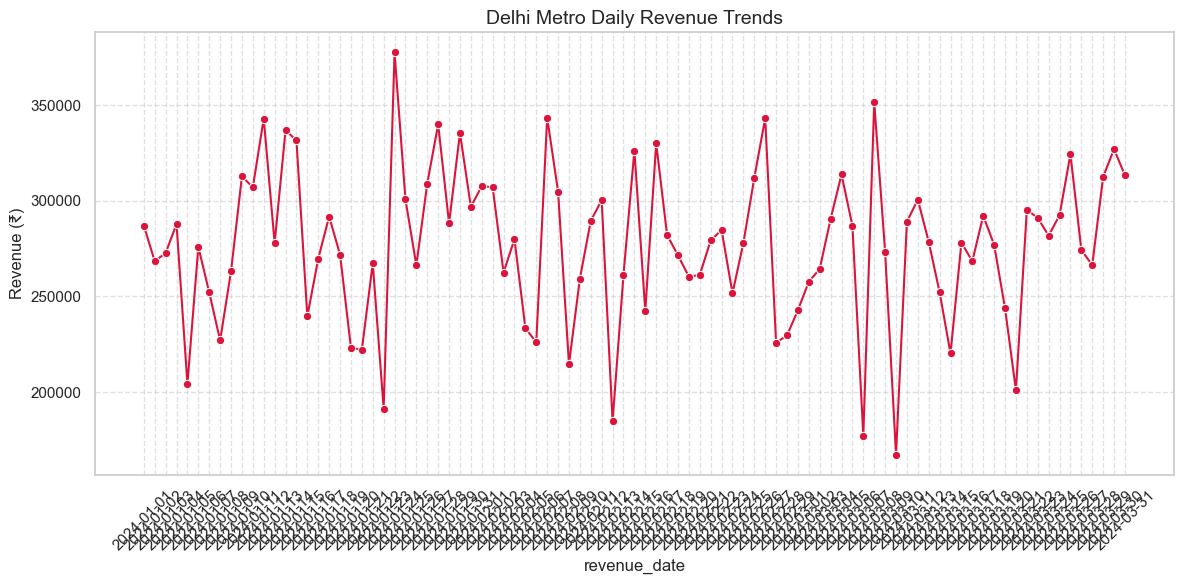

In [5]:
query = """
SELECT revenue_date, SUM(total_revenue) AS daily_revenue
FROM Revenue
GROUP BY revenue_date
ORDER BY revenue_date;
"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="revenue_date", y="daily_revenue", color="crimson", marker="o")
plt.title("Delhi Metro Daily Revenue Trends", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Revenue (₹)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
save_plot(plt.gcf(), title="Delhi Metro Daily Revenue Trends")
plt.show()


C:\Users\shara\AppData\Local\Temp\ipykernel_10844\2562400556.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="station_name", y="total_trips", palette="viridis")


Saved: ../visualizations\top_10_busiest_entry_stations.png


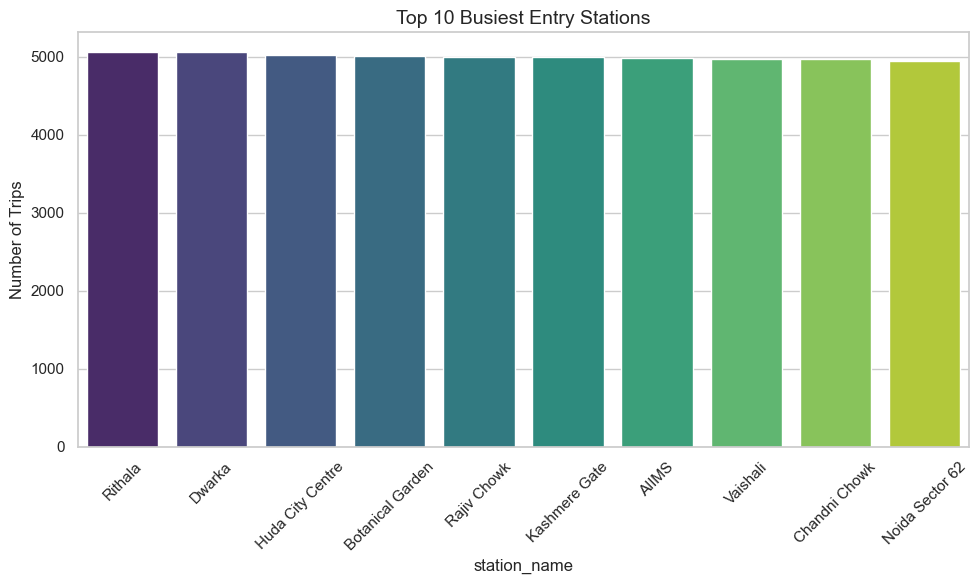

In [7]:
query = """
SELECT s.station_name, COUNT(*) AS total_trips
FROM Trips t
JOIN Stations s ON t.entry_station = s.station_id
GROUP BY s.station_name
ORDER BY total_trips DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="station_name", y="total_trips", palette="viridis")
plt.title("Top 10 Busiest Entry Stations", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("Number of Trips")
plt.tight_layout()
save_plot(plt.gcf(), title="Top 10 Busiest Entry Stations")
plt.show()


Saved: ../visualizations\passenger_gender_distribution.png


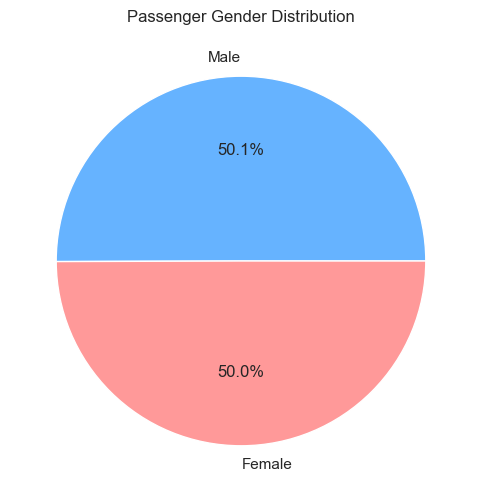

Saved: ../visualizations\passenger_gender_distribution_1.png


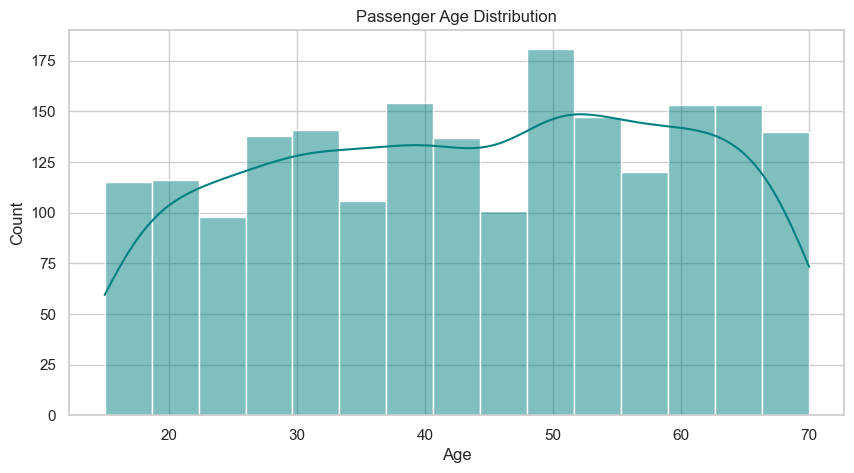

In [10]:
# Gender Distribution
plt.figure(figsize=(6,6))
passengers["gender"].value_counts().plot.pie(autopct="%1.1f%%", colors=["#66b3ff","#ff9999"])
plt.title("Passenger Gender Distribution")
plt.ylabel("")
save_plot(plt.gcf(), title='Passenger Gender Distribution')
plt.show()

# Age Distribution
plt.figure(figsize=(10,5))
sns.histplot(passengers["age"], bins=15, kde=True, color="teal")
plt.title("Passenger Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
for i, f in enumerate(map(plt.figure, plt.get_fignums()), start=1):
    save_plot(f, title=f"passenger_gender_distribution_{i}")
plt.show()


Saved: ../visualizations\trips_by_hour_of_day.png


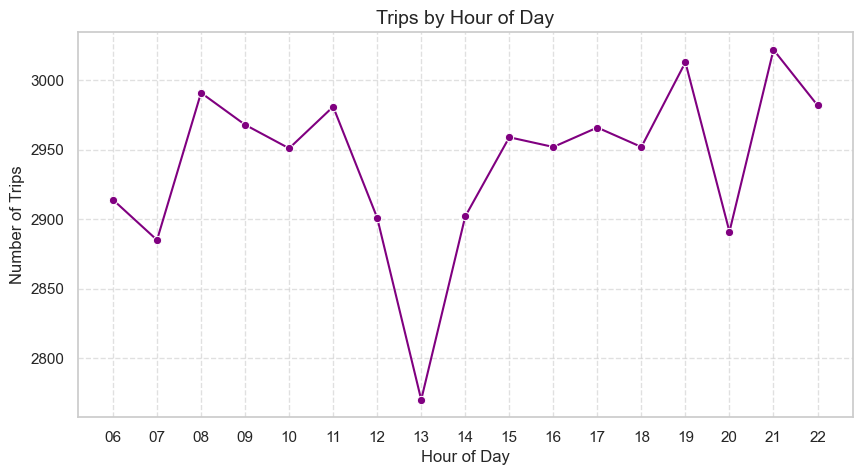

In [12]:
query = """
SELECT strftime('%H', trip_datetime) AS hour, COUNT(*) AS trips_count
FROM Trips
GROUP BY hour
ORDER BY hour;
"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(10,5))
sns.lineplot(data=df, x="hour", y="trips_count", marker="o", color="purple")
plt.title("Trips by Hour of Day", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.grid(True, linestyle="--", alpha=0.6)
save_plot(plt.gcf(), title="Trips by Hour of Day")
plt.show()


Saved: ../visualizations\origin_destination_heatmap_trips_flow.png


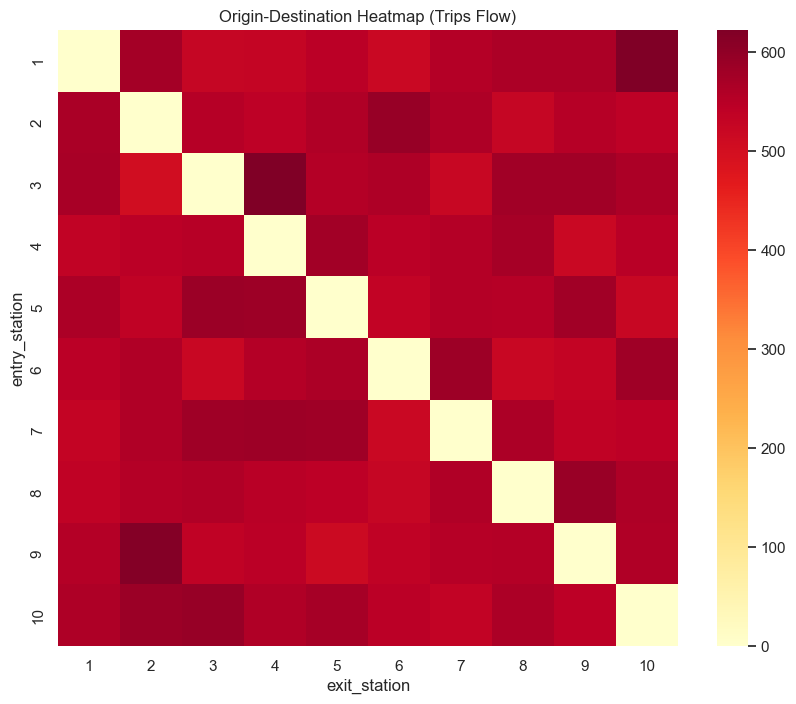

In [14]:
# Origin-Destination (OD) Matrix
od_matrix = trips.groupby(["entry_station", "exit_station"]).size().unstack(fill_value=0)

plt.figure(figsize=(10,8))
sns.heatmap(od_matrix, cmap="YlOrRd", cbar=True)
plt.title("Origin-Destination Heatmap (Trips Flow)")

# Save using our helper (auto-saves into ../visualizations/)
save_plot(plt.gcf(), title="Origin-Destination Heatmap (Trips Flow)")

plt.show()


C:\Users\shara\AppData\Local\Temp\ipykernel_10844\1044157114.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="trip_count", y="zone", data=zone_counts, palette="coolwarm")


Saved: ../visualizations\zone_wise_trip_distribution.png


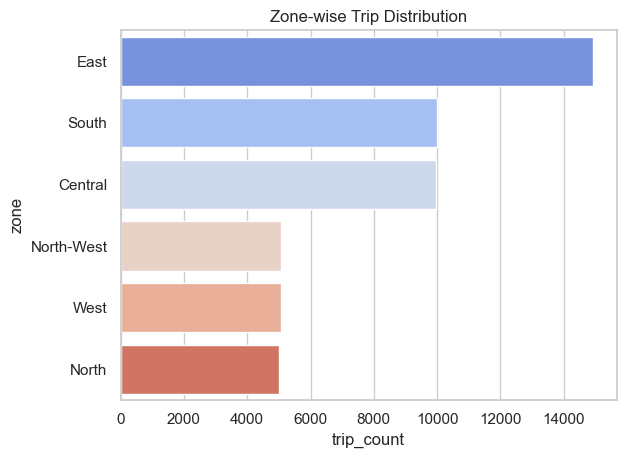

C:\Users\shara\AppData\Local\Temp\ipykernel_10844\1044157114.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_revenue", y="zone", data=rev_zone, palette="mako")


Saved: ../visualizations\zone_wise_revenue_contribution.png


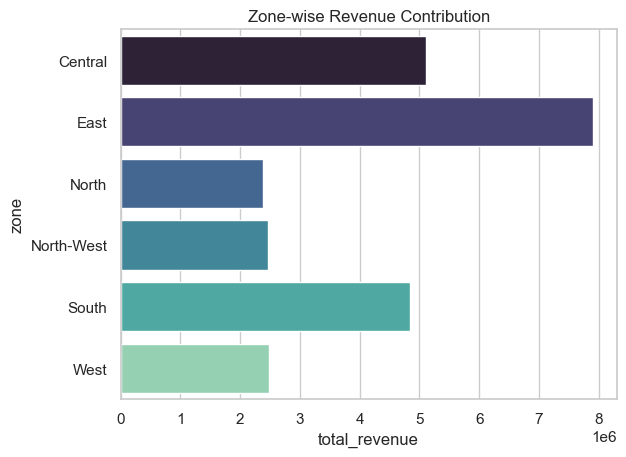

In [16]:
# Join trips with station zones
entry_zone = trips.merge(stations[["station_id","zone"]], 
                         left_on="entry_station", right_on="station_id")
zone_counts = entry_zone["zone"].value_counts().reset_index()
zone_counts.columns = ["zone", "trip_count"]

plt.figure()
sns.barplot(x="trip_count", y="zone", data=zone_counts, palette="coolwarm")
plt.title("Zone-wise Trip Distribution")

# Save first plot
save_plot(plt.gcf(), title="Zone-wise Trip Distribution")

plt.show()

# Revenue by Zone
rev_zone = revenue.merge(stations, on="station_id") \
                  .groupby("zone")["total_revenue"].sum().reset_index()

plt.figure()
sns.barplot(x="total_revenue", y="zone", data=rev_zone, palette="mako")
plt.title("Zone-wise Revenue Contribution")

# Save second plot
save_plot(plt.gcf(), title="Zone-wise Revenue Contribution")

plt.show()
